In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashishkumar2505","key":"5fab177f3e096bfa1289375c1f82ba85"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 3, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 47, in <module>
  File "/usr/local/lib/python3.12/dist-packages/kagglesdk/__init__.py", line 1, in <module>
    from kagglesdk.kaggle_client import KaggleClient
  File "/usr/local/lib/python3.12/dist-packages/kagglesdk/kaggle_client.py", line 4, in <module>
    from kagglesdk.models.services.model_api_service import ModelApiClient
  File "/usr/local/lib/python3.12/dist-packages/kagglesdk/models/services/model_api_service.py", line 3, in <module>
    from kagglesdk.models.types.model_api_service import ApiCreateModelInstanceRequest, ApiCreateModelInstanceVersionRequest, ApiCreateModelRequest, ApiCreateModelResponse, ApiDeleteModelInstanceR

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os

base_dir = "chest_xray"
for split in ["train", "val", "test"]:
    print(split, os.listdir(os.path.join(base_dir, split)))


train ['PNEUMONIA', 'NORMAL']
val ['PNEUMONIA', 'NORMAL']
test ['PNEUMONIA', 'NORMAL']


In [ ]:
def count_images(path):
    return len(os.listdir(path))

for split in ["train", "val", "test"]:
    normal = count_images(f"{base_dir}/{split}/NORMAL")
    pneumonia = count_images(f"{base_dir}/{split}/PNEUMONIA")
    print(f"{split.upper()} → NORMAL: {normal}, PNEUMONIA: {pneumonia}")


TRAIN → NORMAL: 1341, PNEUMONIA: 3875
VAL → NORMAL: 8, PNEUMONIA: 8
TEST → NORMAL: 234, PNEUMONIA: 390


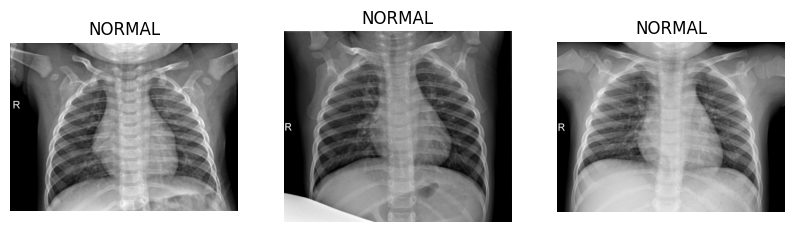

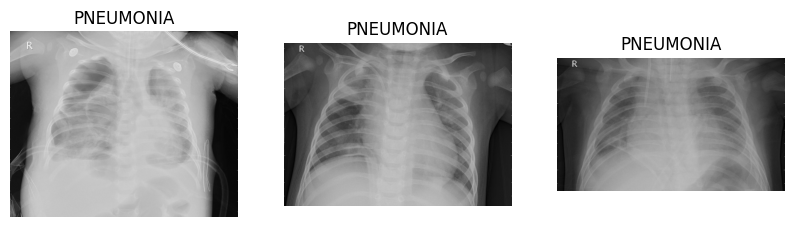

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_images(category, split="train"):
    folder = f"{base_dir}/{split}/{category}"
    images = random.sample(os.listdir(folder), 3)

    plt.figure(figsize=(10,4))
    for i, img in enumerate(images):
        img_path = os.path.join(folder, img)
        image = Image.open(img_path)
        plt.subplot(1,3,i+1)
        plt.imshow(image, cmap="gray")
        plt.title(category)
        plt.axis("off")
    plt.show()

show_images("NORMAL")
show_images("PNEUMONIA")


In [ ]:
img = Image.open(f"{base_dir}/train/NORMAL/{os.listdir(base_dir+'/train/NORMAL')[0]}")
img.size

(1554, 1402)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255
)

val_gen = ImageDataGenerator(
    rescale=1./255
)

train_data = train_gen.flow_from_directory(
    "chest_xray/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    "chest_xray/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "pneumonia_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5

)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 311ms/step - accuracy: 0.7655 - loss: 0.8118 - val_accuracy: 0.9375 - val_loss: 0.1499
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.9636 - loss: 0.0939 - val_accuracy: 0.9375 - val_loss: 0.1559
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.9710 - loss: 0.0840 - val_accuracy: 1.0000 - val_loss: 0.0451
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.9832 - loss: 0.0452 - val_accuracy: 0.8125 - val_loss: 0.4116
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.9869 - loss: 0.0384 - val_accuracy: 0.8750 - val_loss: 0.1262


In [ ]:
model.save("pneumonia_model_checkpoint.h5")


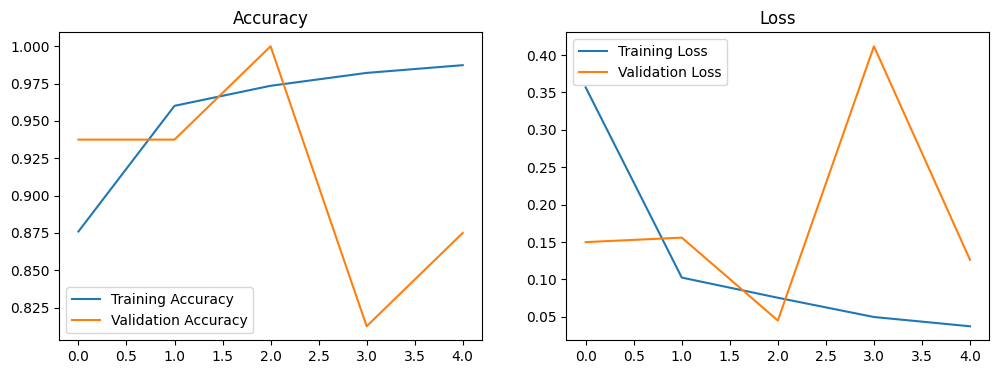

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)


In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 296ms/step - accuracy: 0.8013 - loss: 0.6587 - val_accuracy: 0.8750 - val_loss: 0.3024
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.9460 - loss: 0.1375 - val_accuracy: 0.8125 - val_loss: 0.2706
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.9569 - loss: 0.1055 - val_accuracy: 0.9375 - val_loss: 0.1875
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.9704 - loss: 0.0811 - val_accuracy: 0.9375 - val_loss: 0.1654
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.9752 - loss: 0.0707 - val_accuracy: 0.7500 - val_loss: 0.5434


In [ ]:
model.save("pneumonia_model_checkpoint.h5")


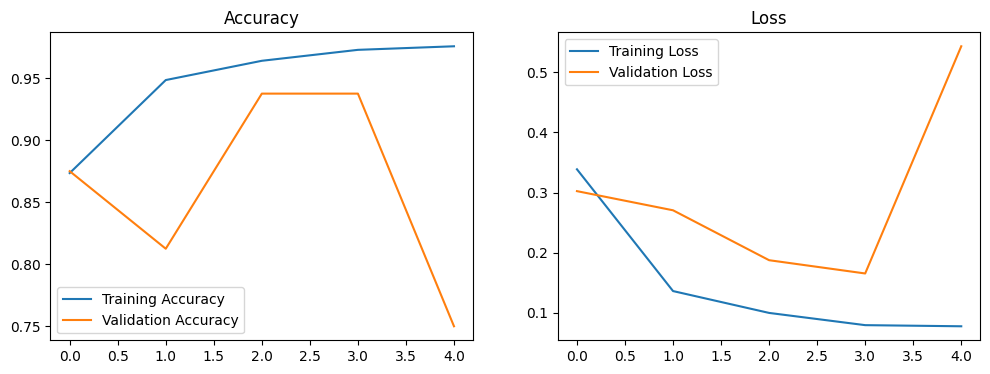

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # FREEZE base model


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)



Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 370ms/step - accuracy: 0.9102 - loss: 0.2165 - val_accuracy: 0.8750 - val_loss: 0.2687
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - accuracy: 0.9690 - loss: 0.0916 - val_accuracy: 0.8125 - val_loss: 0.5172
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.9671 - loss: 0.0885 - val_accuracy: 0.8750 - val_loss: 0.4406
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.9732 - loss: 0.0661 - val_accuracy: 0.8750 - val_loss: 0.2168
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.9709 - loss: 0.0713 - val_accuracy: 0.8750 - val_loss: 0.2241


In [ ]:
model.save("pneumonia_model_checkpoint.h5")


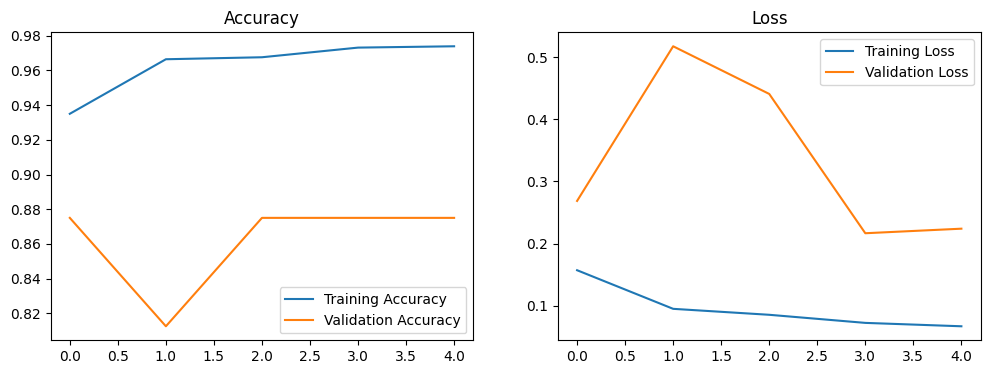

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3
)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 331ms/step - accuracy: 0.9205 - loss: 0.2466 - val_accuracy: 0.8750 - val_loss: 0.2029
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.9670 - loss: 0.0884 - val_accuracy: 0.8750 - val_loss: 0.2431
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 291ms/step - accuracy: 0.9736 - loss: 0.0665 - val_accuracy: 0.8750 - val_loss: 0.2548


In [ ]:
model.save("pneumonia_model_checkpoint.h5")


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    base_dir + "/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)


Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.6820 - loss: 1.2307
Test Accuracy: 0.8092948794364929


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(test_data.classes, y_pred)
print(cm)

print(classification_report(test_data.classes, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 443ms/step
[[121 113]
 [  6 384]]
              precision    recall  f1-score   support

           0       0.95      0.52      0.67       234
           1       0.77      0.98      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624



In [36]:
y_pred = (y_pred > 0.65).astype(int)


In [38]:
!find /content -name "*.h5"


/content/pneumonia_model_checkpoint.h5


In [39]:
from google.colab import files
files.download("/content/pneumonia_model_checkpoint.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>